In [16]:
#Import Necessary Libraries
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

Received an error message so I looked up the error and found that I needed to [change the encodings](https://stackoverflow.com/questions/18171739/unicodedecodeerror-when-reading-csv-file-in-pandas)

In [17]:
#Import Data
df = pd.read_csv('https://raw.githubusercontent.com/josh-g-grimes/Twitter-Sentiment-NLP/main/data.csv', encoding='latin-1')

In [18]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [19]:
df = df.rename(columns={"is_there_an_emotion_directed_at_a_brand_or_product": "tweet_sentiment"})

In [20]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,tweet_sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


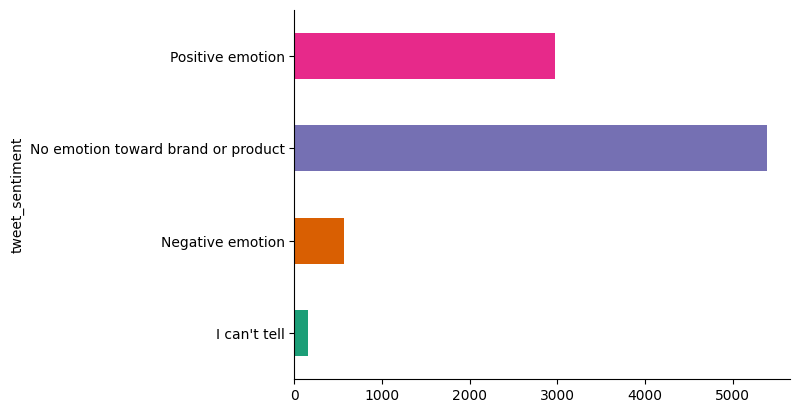

In [21]:
#Look at the distribution of emotions that are directed at brands or products
df.groupby('tweet_sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [22]:
df.drop(columns=['emotion_in_tweet_is_directed_at'], inplace=True)

In [23]:
df['tweet_sentiment'] = df['tweet_sentiment'].map({'Positive emotion': 0, 'Negative emotion': 1})

In [24]:
df = df.dropna()

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3548 entries, 0 to 9088
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tweet_text       3548 non-null   object 
 1   tweet_sentiment  3548 non-null   float64
dtypes: float64(1), object(1)
memory usage: 83.2+ KB


In [26]:
df.head()

,tweet_text,tweet_sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,1.0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,0.0
2,@swonderlin Can not wait for #iPad 2 also. The...,0.0
3,@sxsw I hope this year's festival isn't as cra...,1.0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,0.0


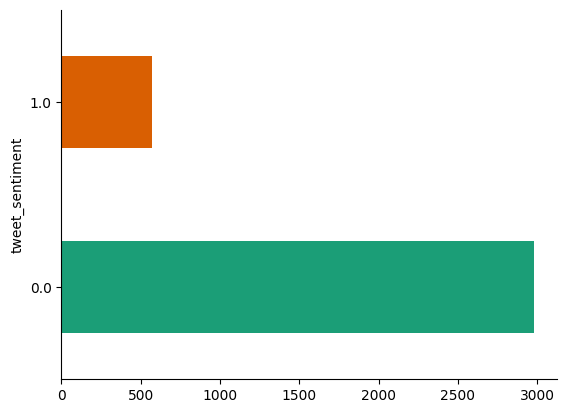

In [27]:
df.groupby('tweet_sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [28]:
X = df['tweet_text']
y = df['tweet_sentiment']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)